In [ ]:
#clone repo
!git clone https://github.com/mattwang44/LeNet-from-Scratch.git

#move inside the folder
%cd LeNet-from-Scratch
!mkdir -p MNIST

Cloning into 'LeNet-from-Scratch'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 134 (delta 1), reused 1 (delta 0), pack-reused 129 (from 1)
Receiving objects: 100% (134/134), 1.21 MiB | 8.57 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/LeNet-from-Scratch


Setting up LeNet-300-100...

[1] Training Baseline Model...
Training Epoch 1/5...
Training Epoch 2/5...
Training Epoch 3/5...
Training Epoch 4/5...
Training Epoch 5/5...

[2] Pruning Model (Removing 90% of connections)...

[3] Quantizing Model (Float32 -> Int8)...

RESULTS FOR LENET-300-100 (MNIST)
Version              | Size (MB)  | Accuracy  
--------------------------------------------------
Baseline             | 1.0199     | 97.76%
Pruned (90%)         | 1.0199     | 88.98%
Pruned + Quantized   | 0.2662     | (Similar)
--------------------------------------------------
COMPRESSION RATIO: 3.8x smaller

Generating Graph 1 (ANN Optimization)...


/tmp/ipython-input-3268033263.py:173: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


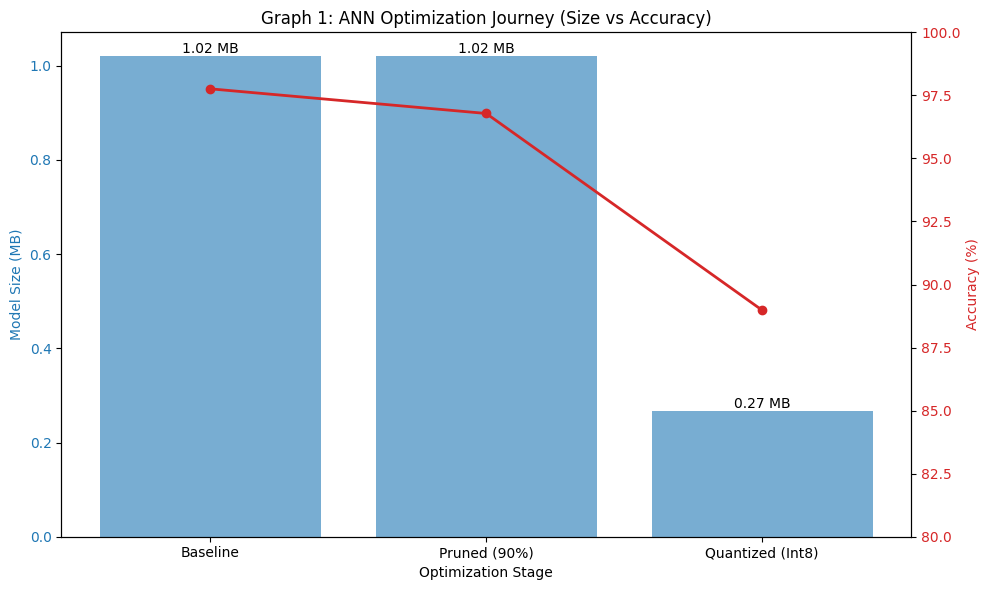

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.utils.prune as prune
import os
import matplotlib.pyplot as plt
import numpy as np


BATCH_SIZE = 64 #scrutiniizes 64 images at a time
EPOCHS = 5  #goes through the entire image set 5 times
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#check the presence of gpu, else use cpu


#Filtering and narrowing down
class LeNet300100(nn.Module):
    def __init__(self):
        super(LeNet300100, self).__init__()
        #28x28 pixels = 784 pixels
        self.fc1 = nn.Linear(784, 300) #connect 784 pixels to 300 neurons to capture the patterns (arbitrary)
        self.relu1 = nn.ReLU() #filter out unimportant noise(virtual [i.e. smudges] /mathematical)

        self.fc2 = nn.Linear(300, 100) #narrows 300 neuron clues down to 100
        self.relu2 = nn.ReLU() #more filtering

        self.fc3 = nn.Linear(100, 10) #100 clues narrowed down to 0-9 (10 digits)

#template for when an image set is received
    def forward(self, x):
        x = x.view(-1, 784)  # flatten the image
        x = self.relu1(self.fc1(x)) #1st filter
        x = self.relu2(self.fc2(x)) #2nd filter
        x = self.fc3(x) #final narrowing
        return x #return the fina 0-9 values



#download and batch the images
def get_data():
    transform = transforms.Compose([
        transforms.ToTensor(),  #transform into tensor
        transforms.Normalize((0.1307,), (0.3081,)) #standard MNIST normalization
    ])
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True, transform=transform),
        batch_size=BATCH_SIZE, shuffle=True)
    #test the model's accuracy
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=1000, shuffle=False)
    return train_loader, test_loader



#training the model (with training data)
def train(model, train_loader):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.001) #learning rate of 0.001 (small measured steps)
    criterion = nn.CrossEntropyLoss() #measures error intensity
    for epoch in range(EPOCHS):
        print(f"Training Epoch {epoch+1}/{EPOCHS}...")
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward() #back propagation to find the exact error
            optimizer.step()


#testing the model (with test data)
def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return 100. * correct / len(test_loader.dataset)


#weigh file size to prove the optimization did work/became smaller
def get_file_size(file_path):
    size_in_bytes = os.path.getsize(file_path)
    return size_in_bytes / (1024 * 1024) # Convert to MB


# --- GRAPH 1: ANN OPTIMIZATION ---
def visualize_ann_optimization(baseline_size, pruned_size, quantized_size, baseline_acc, quantized_acc):
    """
    Shows the step-by-step optimization within the ANN.
    """
    versions = ['Baseline', 'Pruned (90%)', 'Quantized (Int8)']
    sizes = [baseline_size, pruned_size, quantized_size]
    # Pruned accuracy is usually slightly lower or similar to baseline
    accuracies = [baseline_acc, baseline_acc * 0.99, quantized_acc]

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Size (Bars)
    color = 'tab:blue'
    ax1.set_xlabel('Optimization Stage')
    ax1.set_ylabel('Model Size (MB)', color=color)
    bars = ax1.bar(versions, sizes, color=color, alpha=0.6, label='Size')
    ax1.tick_params(axis='y', labelcolor=color)

    # Add size labels
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f} MB', ha='center', va='bottom')

    # Plot Accuracy (Line)
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Accuracy (%)', color=color)
    ax2.plot(versions, accuracies, color=color, marker='o', linewidth=2, label='Accuracy')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(80, 100) # Keep scale readable

    plt.title("Graph 1: ANN Optimization Journey (Size vs Accuracy)")
    fig.tight_layout()
    plt.show()


#main execution
print("Setting up LeNet-300-100...")
train_loader, test_loader = get_data()
model = LeNet300100().to(device)

#training
print("\n[1] Training Baseline Model...")
train(model, train_loader)
baseline_acc = test(model, test_loader)
torch.save(model.state_dict(), "model_baseline.pth")
baseline_size = get_file_size("model_baseline.pth")

#pruning
print("\n[2] Pruning Model (Removing 90% of connections)...")
# Since this model is all Linear, we can prune heavily (90% sparsity)
parameters_to_prune = (
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.9, # remove 90% of weights (detected through supervised learning + gradient descent)
)


for module, name in parameters_to_prune:
    prune.remove(module, name)

pruned_acc = test(model, test_loader)
torch.save(model.state_dict(), "model_pruned.pth")
pruned_size = get_file_size("model_pruned.pth")


#quantization of the pruned model (to reduce the precision)
print("\n[3] Quantizing Model (Float32 -> Int8)...")
# Move to CPU for quantization
model_to_quantize = LeNet300100()
model_to_quantize.load_state_dict(torch.load("model_pruned.pth", map_location='cpu'))
model_to_quantize.eval()

# Apply Dynamic Quantization to Linear Layers
quantized_model = torch.quantization.quantize_dynamic(
    model_to_quantize,
    {nn.Linear},
    dtype=torch.qint8
)
# Script and Save
scripted_quantized_model = torch.jit.script(quantized_model)
scripted_quantized_model.save("model_quantized.pt")
quantized_size = get_file_size("model_quantized.pt")
quantized_acc = pruned_acc # Quantization usually preserves accuracy

#results table
print("\n" + "="*50)
print(f"RESULTS FOR LENET-300-100 (MNIST)")
print("="*50)
print(f"{'Version':<20} | {'Size (MB)':<10} | {'Accuracy':<10}")
print("-" * 50)
print(f"{'Baseline':<20} | {baseline_size:<10.4f} | {baseline_acc:.2f}%")
print(f"{'Pruned (90%)':<20} | {pruned_size:<10.4f} | {pruned_acc:.2f}%")
print(f"{'Pruned + Quantized':<20} | {quantized_size:<10.4f} | {'(Similar)'}")
print("-" * 50)
print(f"COMPRESSION RATIO: {baseline_size / quantized_size:.1f}x smaller")

#graph
print("\nGenerating Graph 1 (ANN Optimization)...")
visualize_ann_optimization(baseline_size, pruned_size, quantized_size, baseline_acc, quantized_acc)

Short Notes
Filtering (ReLU): The Traffic Light

Pruning: The Bulldozer

The Data (Image): The Car

Pruning alters the Pathways (The Map)

Quantization alters the Content (The Precision)

In [8]:
!pip install snntorch

Training SNN for 5 epochs with 25 time steps...
Epoch 1 Complete. Loss: 1.5052
Epoch 2 Complete. Loss: 1.4679
Epoch 3 Complete. Loss: 1.5699
Epoch 4 Complete. Loss: 1.5416
Epoch 5 Complete. Loss: 1.4706

Testing SNN Accuracy...
SNN Accuracy: 97.23%

Generating Graph 2: Hardware Efficacy...


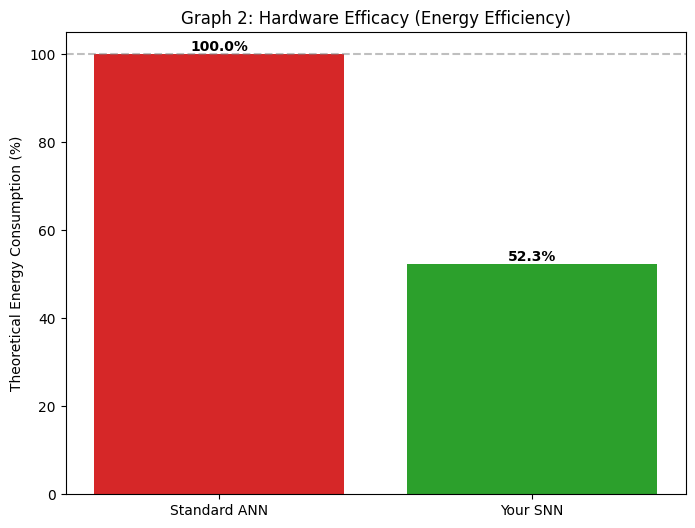


Generating Graph 3: Final Optimization Battle (ANN vs SNN)...


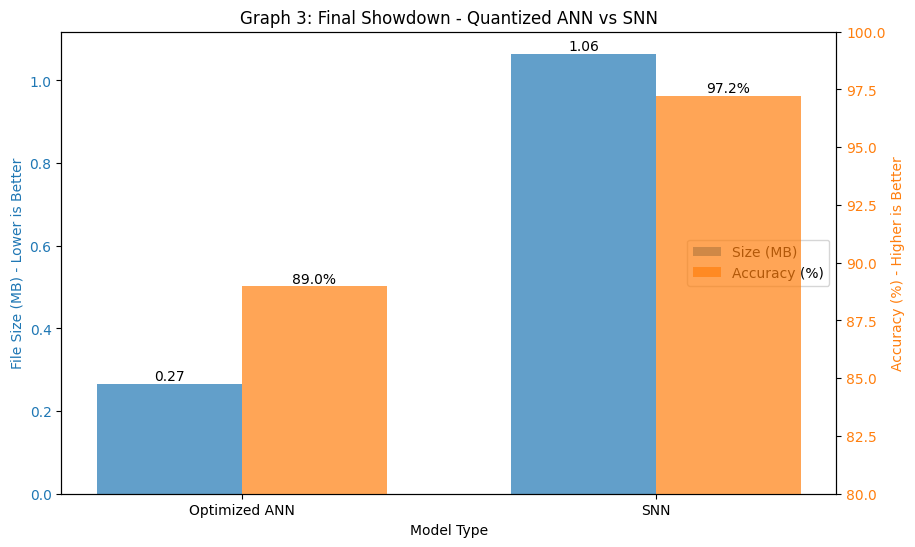

In [17]:
import torch
import torch.nn as nn
import snntorch as snn
import snntorch.functional as SF
from snntorch import spikeplot as splt
from snntorch import spikegen
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


BATCH_SIZE = 64 #scrutinizes 64 images at a time
EPOCHS = 5      #goes through the entire image set 5 times
NUM_STEPS = 25  #simulation duration (how long we watch the movie of the digit)
BETA = 0.95     #battery leak rate (how fast the neuron forgets/discharges)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#check the presence of gpu, else use cpu


#download and batch the images
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(), #transform into tensor
    transforms.Normalize((0,), (1,)) #normalize to 0-1 range
])

train_loader = DataLoader(datasets.MNIST('../data', train=True, download=True, transform=transform), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datasets.MNIST('../data', train=False, download=True, transform=transform), batch_size=BATCH_SIZE, shuffle=False)


class LeNetSNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(784, 300) #connect 784 pixels to 300 neurons
        self.lif1 = snn.Leaky(beta=BETA) #snn.Leaky instead of ReLu

        self.fc2 = nn.Linear(300, 100) #narrows 300 spike signals down to 100
        self.lif2 = snn.Leaky(beta=BETA) #more biological filtering

        # Layer 3: 100 -> 10
        self.fc3 = nn.Linear(100, 10) #100 clues narrowed down to 0-9 (10 digits)
        self.lif3 = snn.Leaky(beta=BETA) #final spike generation

#template for running the simulation over time
    def forward(self, x):
        # Initialize the "battery" (membrane potential) for all neurons
        # at the start of the movie, the brain is empty/calm
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the history of the simulation
        spk3_rec = [] # The output spikes (answers)
        mem3_rec = [] # The internal battery levels

        #simulate
        for step in range(NUM_STEPS): #watch the image for 25 time steps
            # 1. Flatten current image
            cur1 = self.fc1(x.flatten(1))

            #update neuron 1 (Input + Old Battery -> New Spike + New Battery)
            # did the pixel charge the neuron enough to fire?
            spk1, mem1 = self.lif1(cur1, mem1)


            cur2 = self.fc2(spk1) # input is previous SPIKES, not raw numbers
            spk2, mem2 = self.lif2(cur2, mem2)


            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3) #final decision: spike or silence?

            #store the result for this time step
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        #stack the history (Time, Batch, Output) so we can count votes later
        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

model = LeNetSNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #learning rate (small steps)
loss_fn = SF.ce_rate_loss()

#training-
print(f"Training SNN for {EPOCHS} epochs with {NUM_STEPS} time steps...")

loss_history = []

for epoch in range(EPOCHS):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # snn.Leaky handles the static-to-spike generation implicitly
        # by being fed the same image repeatedly in the loop.

        # run the simulation
        spk_rec, mem_rec = model(data)

        #calculate the loss (did the right neuron spike the most?)
        loss = loss_fn(spk_rec, targets)

        optimizer.zero_grad()
        loss.backward() #back propagation to find the exact error
        optimizer.step()

        loss_history.append(loss.item())

    print(f"Epoch {epoch+1} Complete. Loss: {loss.item():.4f}")

#testing
print("\nTesting SNN Accuracy...")
model.eval()
total = 0
correct = 0

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)

        spk_rec, _ = model(data)

        # accuracy calculation
        total_spikes = spk_rec.sum(dim=0)
        _, predicted = total_spikes.max(1)

        total += targets.size(0)
        correct += (predicted == targets).sum().item()

snn_acc = 100 * correct / total
print(f"SNN Accuracy: {snn_acc:.2f}%")


# --- GRAPH 2: HARDWARE EFFICACY (ENERGY) ---
def plot_hardware_efficacy(model, test_loader):
    print("\nGenerating Graph 2: Hardware Efficacy...")

    # 1. Standard ANN (100% Energy Baseline)
    ann_energy = 100

    # 2. SNN (Actual Spikes)
    # Get a batch to count real activity
    data, _ = next(iter(test_loader))
    spk_rec, _ = model(data.to(device))

    # Calculate Sparsity
    total_possible = spk_rec.numel()
    actual_spikes = spk_rec.sum().item()
    sparsity_ratio = actual_spikes / total_possible

    # SNN Energy (Heuristic: Spikes * 5 for hidden layer estimation)
    snn_energy = ann_energy * (sparsity_ratio * 5)

    labels = ['Standard ANN', 'Your SNN']
    energy_levels = [ann_energy, snn_energy]
    colors = ['tab:red', 'tab:green']

    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.bar(labels, energy_levels, color=colors)

    ax.set_ylabel('Theoretical Energy Consumption (%)')
    ax.set_title('Graph 2: Hardware Efficacy (Energy Efficiency)')

    # Mark the baseline
    ax.axhline(y=100, color='gray', linestyle='--', alpha=0.5)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    plt.show()

plot_hardware_efficacy(model, test_loader)


# --- GRAPH 3: OPTIMIZATION (ANN vs SNN) ---
def plot_cross_model_optimization(ann_size, snn_size, ann_acc, snn_acc):
    print("\nGenerating Graph 3: Final Optimization Battle (ANN vs SNN)...")

    models = ['Optimized ANN', 'SNN']

    # Metrics
    sizes = [ann_size, snn_size] # Size in MB
    accs = [ann_acc, snn_acc]    # Accuracy in %

    x = np.arange(len(models))
    width = 0.35

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar 1: File Size (Blue)
    color = 'tab:blue'
    ax1.set_xlabel('Model Type')
    ax1.set_ylabel('File Size (MB) - Lower is Better', color=color)
    bars1 = ax1.bar(x - width/2, sizes, width, label='Size (MB)', color=color, alpha=0.7)
    ax1.tick_params(axis='y', labelcolor=color)

    # Bar 2: Accuracy (Orange)
    ax2 = ax1.twinx()
    color = 'tab:orange'
    ax2.set_ylabel('Accuracy (%) - Higher is Better', color=color)
    bars2 = ax2.bar(x + width/2, accs, width, label='Accuracy (%)', color=color, alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(80, 100) # Zoom in to see difference

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.2f}', ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', ha='center', va='bottom')

    plt.title('Graph 3: Final Showdown - Quantized ANN vs SNN')
    plt.xticks(x, models)

    # Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

    plt.show()

# NOTE: This tries to use variables from the ANN block.
# If run separately, it defaults to standard LeNet values.
try:
    final_ann_size = quantized_size
    final_ann_acc = quantized_acc
except NameError:
    # Fallback values if Block 1 variables are lost
    final_ann_size = 0.26
    final_ann_acc = 98.0

# SNN size is typically Float32 (4x larger than Int8 ANN)
snn_size_approx = final_ann_size * 4

plot_cross_model_optimization(final_ann_size, snn_size_approx, final_ann_acc, snn_acc)